In [20]:
%cd /checkpoint/pfz/2024_logs/0628_segmark_unetplus_nopercep/code/


import json
import argparse
import os
import omegaconf

import torch
from torchvision import transforms

from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

from videoseal.models import Wam, build_embedder, build_extractor
from videoseal.augmentation.augmenter import Augmenter
from videoseal.data.transforms import default_transform, normalize_img, unnormalize_img

/checkpoint/pfz/2024_logs/0628_segmark_unetplus_nopercep/code


In [21]:
def load_model_from_checkpoint(logfile_path, ckpt_path):
    # Load parameters from log file
    with open(logfile_path, 'r') as file:
        for line in file:
            if '__log__:' in line:
                params = json.loads(line.split('__log__:')[1].strip())
                break

    # Create an argparse Namespace object from the parameters
    args = argparse.Namespace(**params)
    
    # Load configurations
    embedder_cfg = omegaconf.OmegaConf.load(args.embedder_config)
    embedder_params = embedder_cfg[args.embedder_model]
    extractor_cfg = omegaconf.OmegaConf.load(args.extractor_config)
    extractor_params = extractor_cfg[extractor_cfg.model]
    augmenter_cfg = omegaconf.OmegaConf.load(args.augmentation_config)
    
    # Build models
    embedder = build_embedder(args.embedder_model, embedder_params, args.nbits)
    extractor = build_extractor(extractor_cfg.model, extractor_params, args.img_size, args.nbits)
    augmenter = Augmenter(**augmenter_cfg)
    
    # Build the complete model
    wam = Wam(embedder, extractor, augmenter, args.scaling_w, args.scaling_i)
    
    # Load the model weights
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        wam.load_state_dict(checkpoint['model'])
        print("Model loaded successfully from", ckpt_path)
        print(line)
    else:
        print("Checkpoint path does not exist:", ckpt_path)
    
    return wam

# Example usage
exp_dir = '/checkpoint/pfz/2024_logs/0628_segmark_unetplus_nopercep'
exp_name = '_scaling_w=0.3_lambda_d=0.0'

logfile_path = os.path.join(exp_dir, 'logs', exp_name + '.stdout')
ckpt_path = os.path.join(exp_dir, exp_name, 'checkpoint.pth')

# logfile_path = '/checkpoint/pfz/2024_logs/0615_segmark_unet_lossi/logs/_embedder_model=unet.stdout'
# ckpt_path = '/checkpoint/pfz/2024_logs/0615_segmark_unet_lossi/_embedder_model=unet/checkpoint.pth'

# logfile_path = '/checkpoint/pfz/2024_logs/0821_segmark_ftjnd_32b/logs/_scaling_w=1.0.stdout'
# ckpt_path = '/checkpoint/pfz/2024_logs/0821_segmark_ftjnd_32b/_scaling_w=1.0/checkpoint.pth'

wam = load_model_from_checkpoint(logfile_path, ckpt_path)
wam.eval()
wam.cuda()

Model loaded successfully from /checkpoint/pfz/2024_logs/0628_segmark_unetplus_nopercep/_scaling_w=0.3_lambda_d=0.0/checkpoint.pth
__log__:{"train_dir": "/datasets01/COCO/060817/train2014/", "train_annotation_file": "/datasets01/COCO/060817/annotations/instances_train2014.json", "val_dir": "/datasets01/COCO/060817/test2014/", "output_dir": "/checkpoint/pfz/2024_logs/0628_segmark_unetplus_nopercep/_scaling_w=0.3_lambda_d=0.0", "embedder_config": "configs/embedder.yaml", "augmentation_config": "configs/all_augs.yaml", "extractor_config": "configs/extractor.yaml", "embedder_model": "unet_plus_small", "extractor_model": "sam_small", "nbits": 16, "img_size": 256, "scaling_w": 0.3, "scaling_w_schedule": null, "scaling_i": 1.0, "double_w": false, "optimizer": "AdamW,lr=1e-4", "optimizer_d": null, "scheduler": "CosineLRScheduler,lr_min=1e-6,t_initial=200,warmup_lr_init=1e-6,warmup_t=5", "epochs": 200, "batch_size": 16, "batch_size_eval": 64, "temperature": 1.0, "workers": 8, "resume_from": nul

/tmp/ipykernel_1857606/3364721921.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Wam(
  (embedder): UnetEmbedder(
    (unet): UNetMsgPlus(
      (msg_processor): MsgProcessor(
        (msg_embeddings): Embedding(32, 32)
      )
      (inc): ResnetBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ChanRMSNorm()
          (2): SiLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ChanRMSNorm()
          (5): SiLU()
        )
        (res_conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (downs): ModuleList(
        (0): DBlock(
          (down): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv): ResnetBlock(
            (double_conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): ChanRMSNorm()
              (2): SiLU()
              (3): Conv2d(32, 32, kernel_size=(3, 3), stride

In [22]:
print(os.listdir("/private/home/pfz/_images"))
# img = "/private/home/pfz/_images/chao.png"
img = "/private/home/pfz/_images/trex_bike.png"
img = Image.open(img, "r").convert("RGB")  # keep only rgb channels

# resize to 256x256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
])
img = transform(img)

['chao.png', 'corgi_avocado.png', 'trex_bike.png', 'tahiti.webp', 'tahiti.png', 'tahiti_512.png', 'tahiti_256.png', 'gauguin.jpg', 'gauguin.png', 'gauguin_512.png', 'gauguin_256.png', 'hific.png', 'gfpgan.png', 'woman.png', 'gfpgan_hf.png', 'tahiti_photo.png', 'pope.png', 'blogpost', 'blogpost_w']


In [23]:
import matplotlib.pyplot as plt
import numpy as np

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((256, 256))

@torch.no_grad()
def test_model_on_image(
    model: Wam,
    imgs: torch.Tensor, 
    masks: torch.Tensor
) -> dict:
    """
    Test the given model on the provided image tensor, create the watermarked image, and plot the results.
    
    Args:
    - model: The trained model.
    - imgs: A tensor representing the image, normalized as wam.
    - masks: A tensor representing the masks to be applied to the watermarked image.
    """
    # Generate random message for watermarking
    msgs = model.get_random_msg(img_pt.shape[0])  # b x k
    msgs = msgs.to('cuda')

    # Generate watermark delta
    delta = model.embedder(imgs, msgs)
    
    # Create watermarked image
    imgs_w =  model.scaling_i * imgs + model.scaling_w * delta
    
    # resize to 256x256 and augment
    imgs_masked = imgs_w * masks + imgs * (1 - masks)
    imgs_aug = imgs_masked
    imgs_aug = resize(imgs_aug)

    # detect watermark
    preds = wam.detector(imgs_aug)
    mask_preds = preds[:, 0:1, :, :]  # b h w
    bit_preds = preds[:, 1:, :, :]  # b k h w

    outputs = {
        'imgs': imgs,  # b 3 h w
        'imgs_w': imgs_w,  # b 3 h w
        'masks': masks,  # b 1 h w
        'mask_preds': mask_preds,  # b 1 h w
        'msgs': msgs,  # b k
        'bit_preds': bit_preds,  # b k h w
    }
    return outputs

# Example usage:
# Assuming outputs is the dictionary returned from test_model_on_image function
# plot_outputs(outputs)

# Assuming 'model' is loaded from the previous function
# Assuming 'img_pt' is the preprocessed image tensor
img_pt = default_transform(img).unsqueeze(0).cuda()
mask = torch.zeros_like(img_pt)[0:1, 0:1, :, :]
mask[:, :, 100:500, 100:500] = 1
outputs = test_model_on_image(wam, img_pt, mask)

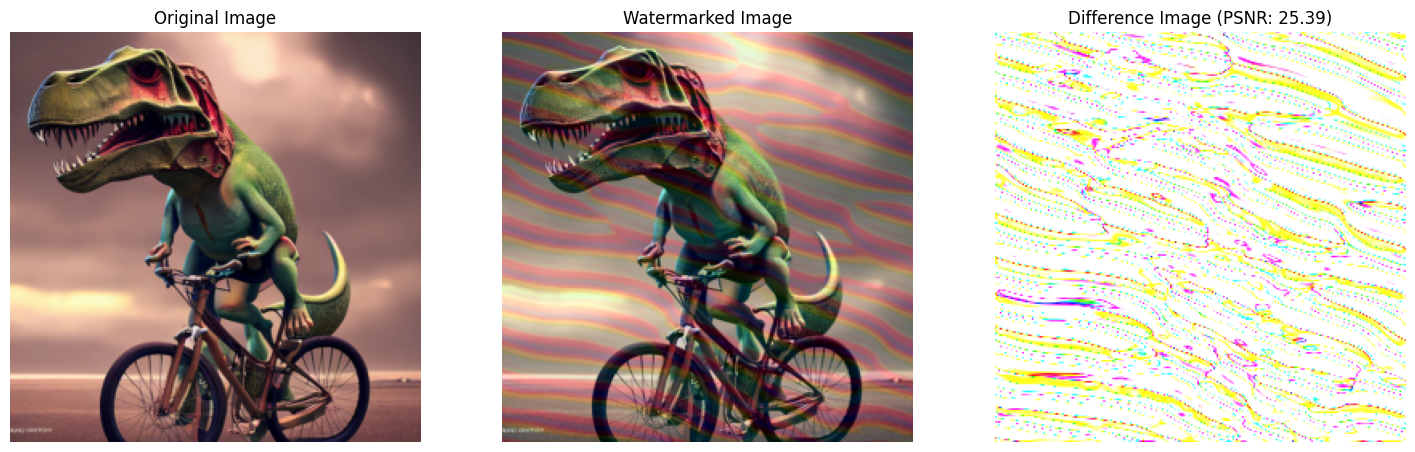

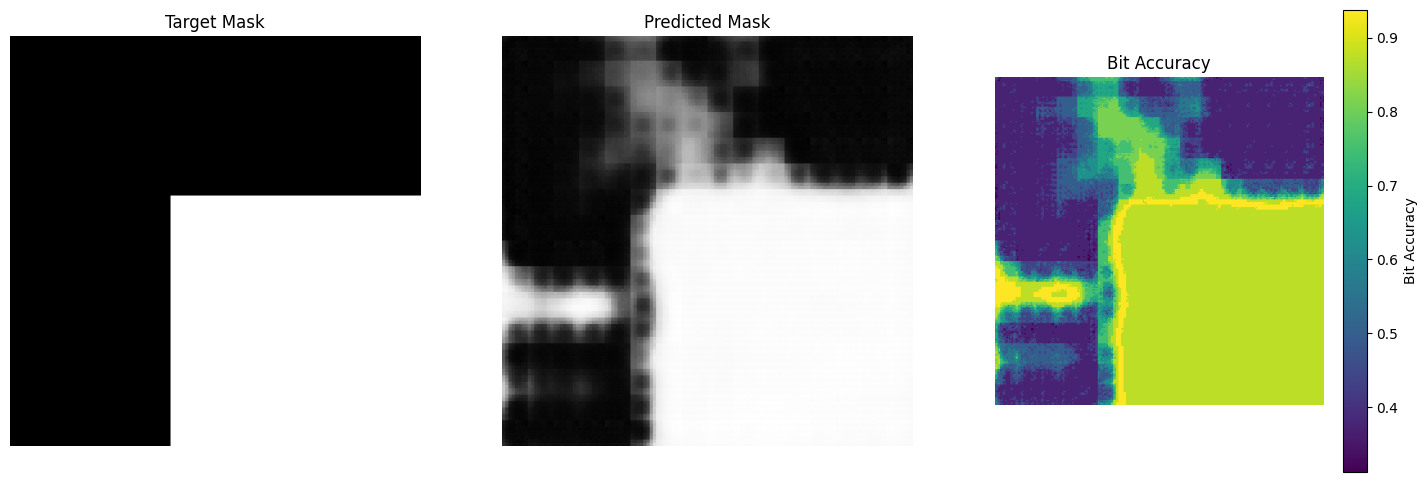

In [24]:
def torch_to_np(img_tensor):
    img_tensor = unnormalize_img(img_tensor).clamp(0, 1)
    img_tensor = img_tensor.squeeze().permute(1, 2, 0).cpu()
    return img_tensor.numpy()

def plot_outputs(outputs):
    """
    Plot the outputs from the test_model_on_image function.
    
    Args:
    - outputs: A dictionary containing the outputs from the test_model_on_image function.
    """
    # prepare images
    imgs = torch_to_np(outputs['imgs'])
    imgs_w = torch_to_np(outputs['imgs_w'])
    delta = (outputs['imgs_w'] - outputs['imgs']).squeeze().permute(1, 2, 0).cpu().numpy()
    delta = np.clip(np.abs(10 * delta), 0, 1)
    psnr = peak_signal_noise_ratio(imgs, imgs_w)
    
    # plot images: original, watermarked, difference
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(imgs)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(imgs_w)
    plt.title('Watermarked Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(delta), cmap='hot')
    plt.title('Difference Image (PSNR: {:.2f})'.format(psnr))
    plt.axis('off')
    plt.show()

    # prepare masks
    preds = outputs['bit_preds'] > 0.5
    targets = outputs['msgs']
    correct = (preds == targets.unsqueeze(-1).unsqueeze(-1)).float()  # b k h w
    bit_accs = correct.mean(dim=1)  # b h w
    masks_target = outputs['masks'].squeeze().cpu().numpy()
    mask_preds = outputs['mask_preds'].squeeze().cpu().numpy()
    bit_accs = bit_accs.squeeze().cpu().numpy()

    # plot masks
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(masks_target, cmap='gray')
    plt.title('Target Mask')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask_preds, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(bit_accs, cmap='viridis')
    plt.title('Bit Accuracy')
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label('Bit Accuracy')
    plt.show()

plot_outputs(outputs)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 3, 128, 128])
torch.Size([1, 3, 3, 64, 64])
torch.Size([1, 3, 3, 32, 32])


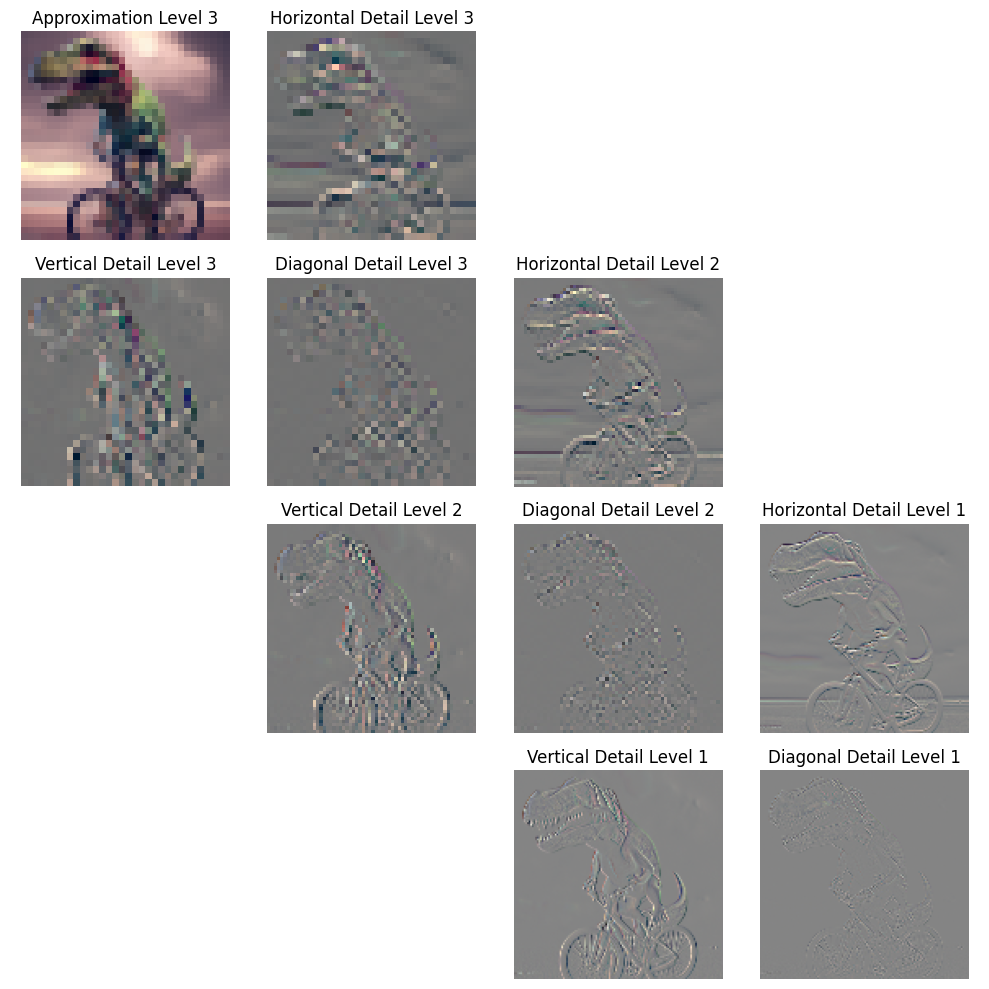

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '/private/home/pfz/07-segmark/2404-dev/src/losses/')
from dwt import DWTForward, DWTInverse

# Assuming X is your input tensor
xfm = DWTForward(J=3, wave='haar', mode='zero')

Yl, Yh = xfm(img_pt.cpu())

print(Yl.shape)
print(Yh[0].shape)
print(Yh[1].shape)
print(Yh[2].shape)

# Function to normalize coefficients for visualization
def normalize_coeffs(Yl, Yh):
    Yl_norm = (Yl - Yl.min()) / (Yl.max() - Yl.min())
    Yh_norm = []
    for level in Yh:
        level_norm = tuple((c - c.min()) / (c.max() - c.min()) for c in level)
        Yh_norm.append(level_norm)
    return Yl_norm, Yh_norm

Yl_norm, Yh_norm = normalize_coeffs(Yl, Yh)

# Function to plot the decomposition
def plot_dwt_decomposition(Yl_norm, Yh_norm):
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(4):
        for j in range(4):
            ax[i, j].axis('off')

    Y_level1 = Yh_norm[0][0]  # 1 3 3 h w -> 3 3 h w
    Y_level2 = Yh_norm[1][0]
    Y_level3 = Yh_norm[2][0]

    # Level 3
    ax[0, 0].imshow(Yl_norm.squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[0, 0].set_title('Approximation Level 3')
    ax[0, 1].imshow(Y_level3[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].set_title('Horizontal Detail Level 3')
    ax[1, 0].imshow(Y_level3[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 0].set_title('Vertical Detail Level 3')
    ax[1, 1].imshow(Y_level3[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 1].set_title('Diagonal Detail Level 3')

    # Level 2
    ax[1, 2].imshow(Y_level2[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 2].set_title('Horizontal Detail Level 2')
    ax[2, 1].imshow(Y_level2[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 1].set_title('Vertical Detail Level 2')
    ax[2, 2].imshow(Y_level2[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 2].set_title('Diagonal Detail Level 2')

    # Level 1
    ax[2, 3].imshow(Y_level1[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 3].set_title('Horizontal Detail Level 1')
    ax[3, 2].imshow(Y_level1[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[3, 2].set_title('Vertical Detail Level 1')
    ax[3, 3].imshow(Y_level1[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[3, 3].set_title('Diagonal Detail Level 1')

    plt.tight_layout()
    plt.show()

plot_dwt_decomposition(Yl_norm, Yh_norm)

# Inverse DWT
ifm = DWTInverse(wave='haar', mode='zero')
Y = ifm((Yl, Yh))